In [2]:
import numpy as np 
import pandas as pd 
import os
from pandas.io.json import json_normalize,loads
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, KFold

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



1. JSON Parsing to a DataFrame

In [3]:
columns = ['device', 'geoNetwork', 'totals', 'trafficSource']

In [4]:
train_path = "../hw3_data/train.csv"
test_path = "../hw3_data/test.csv"

In [5]:
def load_json(d):
    return loads(d)

In [6]:
def json_into_dataframe(dataframe,column):
    return json_normalize(dataframe[column].apply(load_json).tolist()).add_prefix(column +'.')


In [7]:
data= pd.read_csv(train_path, low_memory = False)

Extract The JSON Columns as a data frame named temp, If some columns in the df are all same 

In [8]:
def open_flat(filepath,columns):
    counter = 0 
    data= pd.read_csv(filepath, low_memory = False)
    for column in columns :
        print ('Unpacking ' + column)
        temp = json_into_dataframe(dataframe = data, column = column)
        for item in temp.columns:
            if len(temp[item].unique()) == 1: # if a column has the same value for all rows is not significant
                temp.drop(item, axis = 1, inplace = True)
                print ('column '+ item + ' was dropped')
                counter += 1
        data = pd.concat([data,temp], axis = 1)
        data.drop([column],inplace = True, axis = 1)  # now you don't need the json column in the data frame.
    print ('Columns dropped :',counter)
    return data

In [9]:
train_parsed_df = open_flat(train_path, columns)

Unpacking device
column device.browserSize was dropped
column device.browserVersion was dropped
column device.flashVersion was dropped
column device.language was dropped
column device.mobileDeviceBranding was dropped
column device.mobileDeviceInfo was dropped
column device.mobileDeviceMarketingName was dropped
column device.mobileDeviceModel was dropped
column device.mobileInputSelector was dropped
column device.operatingSystemVersion was dropped
column device.screenColors was dropped
column device.screenResolution was dropped
Unpacking geoNetwork
column geoNetwork.cityId was dropped
column geoNetwork.latitude was dropped
column geoNetwork.longitude was dropped
column geoNetwork.networkLocation was dropped
Unpacking totals
column totals.visits was dropped
Unpacking trafficSource
column trafficSource.adwordsClickInfo.criteriaParameters was dropped
Columns dropped : 18


In [10]:
test_parsed_df = open_flat(test_path, columns)

Unpacking device
column device.browserSize was dropped
column device.browserVersion was dropped
column device.flashVersion was dropped
column device.language was dropped
column device.mobileDeviceBranding was dropped
column device.mobileDeviceInfo was dropped
column device.mobileDeviceMarketingName was dropped
column device.mobileDeviceModel was dropped
column device.mobileInputSelector was dropped
column device.operatingSystemVersion was dropped
column device.screenColors was dropped
column device.screenResolution was dropped
Unpacking geoNetwork
column geoNetwork.cityId was dropped
column geoNetwork.latitude was dropped
column geoNetwork.longitude was dropped
column geoNetwork.networkLocation was dropped
Unpacking totals
column totals.visits was dropped
Unpacking trafficSource
column trafficSource.adwordsClickInfo.criteriaParameters was dropped
Columns dropped : 18


Do The Same preprocessing for NON-JSON columns as well

In [11]:
def drop_redundant_cols(parsed_df):
    for column in parsed_df.columns:
        if len(parsed_df[column].unique()) == 1:
            parsed_df.drop(column, axis=1, inplace = True)
            print ('column '+ column + ' was dropped')

In [12]:
drop_redundant_cols(train_parsed_df)

column socialEngagementType was dropped


In [13]:
drop_redundant_cols(test_parsed_df)

column socialEngagementType was dropped


In [14]:
print(train_parsed_df.shape)
print(test_parsed_df.shape)

(903653, 36)
(804684, 34)


There are columns in train_dataframe apart from revenue that is not in test_dataframe,
so we must get rid of those columns as well.

In [15]:
for column in train_parsed_df.columns:
    if column not in test_parsed_df.columns:
        print(column)

totals.transactionRevenue
trafficSource.campaignCode


Dropping trafficSource.campaignCode from train_parsed_df

In [16]:
train_parsed_df.drop('trafficSource.campaignCode' , axis = 1 , inplace = True)

In [17]:
print(train_parsed_df.shape)
print(test_parsed_df.shape)

(903653, 35)
(804684, 34)


Saving Both train.csv and test.csv as Parsed_train.csv and Parsed_test.csv

In [4]:
train_parsed_df.to_csv('../hw3_data/parsed_train.csv', mode='w', index=False)

NameError: name 'train_parsed_df' is not defined

In [20]:
test_parsed_df.to_csv('../hw3_data/parsed_test.csv', mode='w', index=False)

2. Data Cleaning

On visual inspection, I found channelGrouping column and trafficSource.medium to be same. 
So dropping trafficSource.medium.

In [5]:
train_data=pd.read_csv('../hw3_data/parsed_train.csv', low_memory = False)

In [6]:
test_data=pd.read_csv('../hw3_data/parsed_test.csv', low_memory = False)

In [7]:
train_data['trafficSource.medium'].head(5)

0    organic
1    organic
2    organic
3    organic
4    organic
Name: trafficSource.medium, dtype: object

In [8]:
train_data.drop('trafficSource.medium' , axis = 1 , inplace = True)

In [9]:
test_data.drop('trafficSource.medium' , axis = 1 , inplace = True)

In [10]:
print(train_data.shape)

(903653, 34)


In [11]:
train_data.head(5)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,google + online,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,NaN,NaN,NaN,NaN,NaN,(not set),True,(not provided),NaN,google


In [12]:
train_data.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.source'],
      dtype='object')

In [13]:
def process_date_time(data_df):
    data_df['date'] = data_df['date'].astype(str)
    data_df["date"] = data_df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    data_df["date"] = pd.to_datetime(data_df["date"])   
    data_df["year"] = data_df['date'].dt.year
    data_df["month"] = data_df['date'].dt.month
    data_df["day"] = data_df['date'].dt.day
    data_df["weekday"] = data_df['date'].dt.weekday
    return data_df

In [14]:
train_data = process_date_time(train_data)

Transformed Data set is:

In [15]:
print("Train set:",train_data.shape[0]," rows, ", train_data.shape[1],"columns")

Train set: 903653  rows,  38 columns


In [16]:
test_data.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.source'],
      dtype='object')

In [17]:
test_data = process_date_time(test_data)

In [18]:
print("Test set:",test_data.shape[0]," rows, ", test_data.shape[1],"columns")

Test set: 804684  rows,  37 columns


Exploring the Missing Data for each Column

Missing Data-

In [19]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return df.loc[~(df['Total']==0)]

In [20]:
def fill_missing_data(df):
    for col in ['trafficSource.adwordsClickInfo.page','totals.bounces', 
                'totals.pageviews', 'totals.newVisits']:
        df[col].fillna(0.0, inplace = True)
        df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
        df['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [21]:
missing_data(test_data)

,Total,Percent
trafficSource.adContent,750893,93.315264
trafficSource.adwordsClickInfo.slot,750870,93.312406
trafficSource.adwordsClickInfo.adNetworkType,750870,93.312406
trafficSource.adwordsClickInfo.isVideoAd,750870,93.312406
trafficSource.adwordsClickInfo.page,750870,93.312406
trafficSource.adwordsClickInfo.gclId,750822,93.306441
trafficSource.referralPath,569361,70.755850
trafficSource.isTrueDirect,544171,67.625428
trafficSource.keyword,391032,48.594479
totals.bounces,383736,47.687788


In [22]:
fill_missing_data(test_data)

In [23]:
fill_missing_data(train_data)

In [24]:
missing_data(train_data)

,Total,Percent
trafficSource.adContent,892707,98.788694
totals.transactionRevenue,892138,98.725728
trafficSource.adwordsClickInfo.adNetworkType,882193,97.625195
trafficSource.adwordsClickInfo.slot,882193,97.625195
trafficSource.adwordsClickInfo.gclId,882092,97.614018
trafficSource.referralPath,572712,63.377425
trafficSource.keyword,502929,55.655102


In [25]:
cols_missing = ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId', 'trafficSource.keyword']
def drop_remaining_missing(df):
    df.drop(cols_missing, axis=1, inplace=True)

In [26]:
drop_remaining_missing(train_data)

In [27]:
drop_remaining_missing(test_data)

## The remaining missing data columns are String, hence we are not filling it with 0.0 or False.

In [28]:
missing_data(train_data)

,Total,Percent
totals.transactionRevenue,892138,98.725728
trafficSource.referralPath,572712,63.377425


Total.transaction revenue should be made 0 whereever its null or empty.

In [29]:
train_data['totals.transactionRevenue'].fillna(0, inplace = True)
train_data['totals.transactionRevenue'].describe()

count    9.036530e+05
mean     1.704273e+06
std      5.277866e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

In [30]:
train_data['totals.transactionRevenue'].isnull().count()

903653

A utility function which helps us to know the distribution of categorical features-

In [67]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000)/100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

In [68]:
get_feature_distribution(train_data,'channelGrouping')

Organic Search                :   381561 or 42.22%
Social                        :   226117 or 25.02%
Direct                        :   143026 or 15.82%
Referral                      :   104838 or 11.6%
Paid Search                   :   25326 or 2.8%
Affiliates                    :   16403 or 1.81%
Display                       :   6262 or 0.69%
(Other)                       :   120 or 0.01%


There are 4 device attributes that must be analysed - 
'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem'

In [69]:
get_feature_distribution(train_data, 'device.browser')

Chrome                        :   620364 or 68.65%
Safari                        :   182245 or 20.16%
Firefox                       :   37069 or 4.1%
Internet Explorer             :   19375 or 2.14%
Edge                          :   10205 or 1.12%
Android Webview               :   7865 or 0.87%
Safari (in-app)               :   6850 or 0.75%
Opera Mini                    :   6139 or 0.67%
Opera                         :   5643 or 0.62%
UC Browser                    :   2427 or 0.26%
YaBrowser                     :   2096 or 0.23%
Coc Coc                       :   727 or 0.08%
Amazon Silk                   :   561 or 0.06%
Android Browser               :   553 or 0.06%
Mozilla Compatible Agent      :   374 or 0.04%
MRCHROME                      :   263 or 0.02%
Maxthon                       :   246 or 0.02%
BlackBerry                    :   184 or 0.02%
Nintendo Browser              :   140 or 0.01%
Puffin                        :   93 or 0.01%
Nokia Browser                 :   67 or 0.

All Browsers after Edge should be grouped under other Browsers.

Applying same analysis on 
'device.deviceCategory', 'device.operatingSystem',
'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',

In [70]:
get_feature_distribution(train_data, 'device.deviceCategory')

desktop                       :   664479 or 73.53%
mobile                        :   208725 or 23.09%
tablet                        :   30449 or 3.36%


device.deviceCategory looks to be a good categorical feature.

In [71]:
def getCount():
    mobil = 0
    nomobil = 0
    for index, row in train_data.iterrows():
        if row['device.isMobile']==True:
            mobil += 1;
        else:
            nomobil += 1;
    print('Mobil count:', mobil, ' Not mobil count:', nomobil)


In [72]:
getCount()

Mobil count: 239123  Not mobil count: 664530


In [73]:
get_feature_distribution(train_data, 'device.operatingSystem')

Windows                       :   350072 or 38.73%
Macintosh                     :   253938 or 28.1%
Android                       :   123892 or 13.71%
iOS                           :   107665 or 11.91%
Linux                         :   35034 or 3.87%
Chrome OS                     :   26337 or 2.91%
(not set)                     :   4695 or 0.51%
Windows Phone                 :   1216 or 0.13%
Samsung                       :   280 or 0.03%
BlackBerry                    :   218 or 0.02%
Nintendo Wii                  :   100 or 0.01%
Firefox OS                    :   89 or 0.0%
Xbox                          :   66 or 0.0%
Nintendo WiiU                 :   35 or 0.0%
FreeBSD                       :   9 or 0.0%
Nokia                         :   2 or 0.0%
OpenBSD                       :   2 or 0.0%
SunOS                         :   1 or 0.0%
NTT DoCoMo                    :   1 or 0.0%
Nintendo 3DS                  :   1 or 0.0%


In [74]:
get_feature_distribution(train_data, 'geoNetwork.continent')

Americas                      :   450377 or 49.83%
Asia                          :   223698 or 24.75%
Europe                        :   198311 or 21.94%
Oceania                       :   15054 or 1.66%
Africa                        :   14745 or 1.63%
(not set)                     :   1468 or 0.16%


GeoNetwork Graphs

## Q2 Generate a heatmap and two other plots (with a subset of variables) visualizing interesting positive and negative correlations

In [75]:
import seaborn as sns
tmp = train_data.groupby(['device.browser', 'device.operatingSystem'])['totals.transactionRevenue'].sum()
df1 = tmp.reset_index()
matrix = df1.pivot('device.browser', 'device.operatingSystem', 'totals.transactionRevenue')

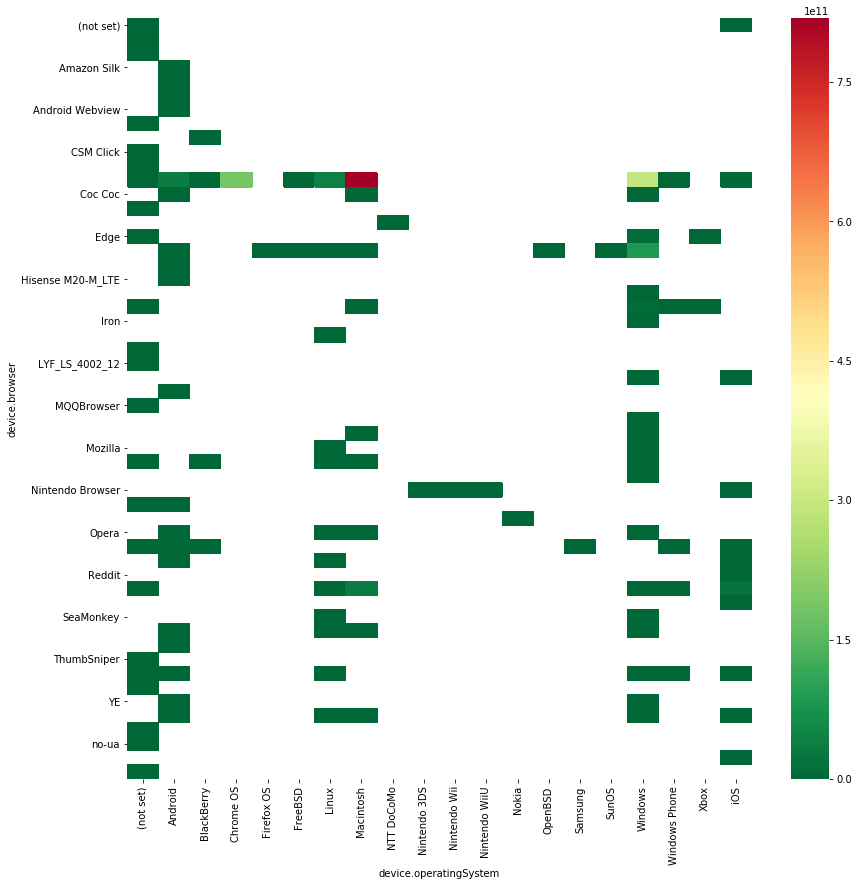

In [76]:
import matplotlib.pyplot as plt
df = pd.DataFrame(matrix, index=matrix.index,
               columns=matrix.columns)
sns.heatmap(df, cmap='RdYlGn_r')
plt.gcf().set_size_inches(14,14)
plt.show()

In [80]:
import seaborn as sns
tmp = train_data.groupby(['device.browser', 'device.deviceCategory'])['totals.transactionRevenue'].sum()
df1 = tmp.reset_index()
matrix = df1.pivot('device.browser', 'device.deviceCategory', 'totals.transactionRevenue')

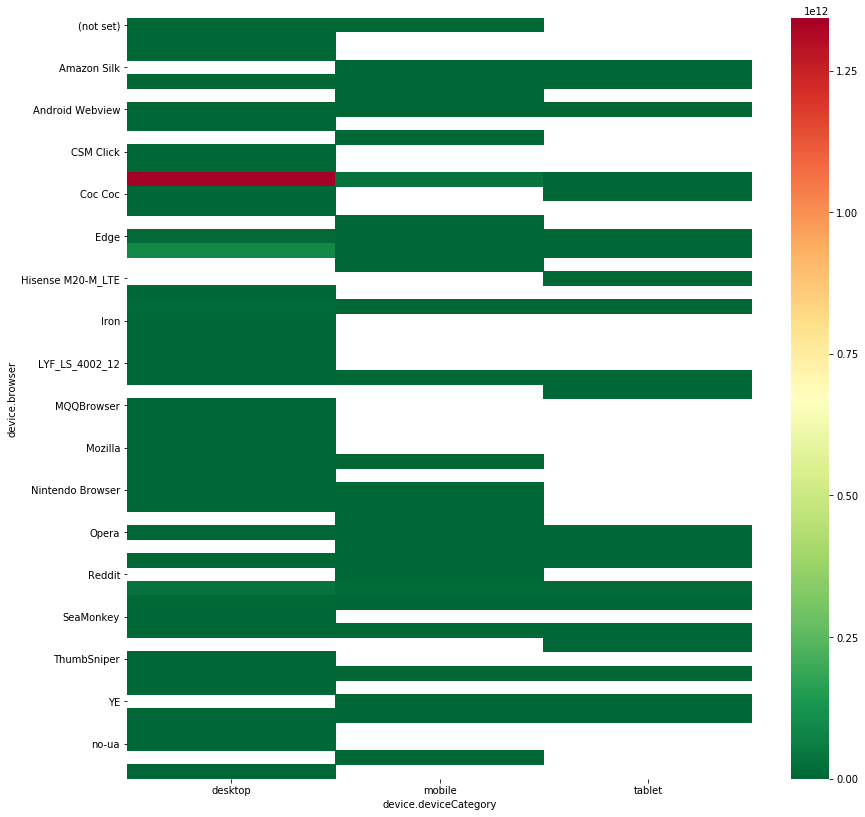

In [81]:
import matplotlib.pyplot as plt
df = pd.DataFrame(matrix, index=matrix.index,
               columns=matrix.columns)
sns.heatmap(df, cmap='RdYlGn_r')
plt.gcf().set_size_inches(14,14)
plt.show()

In [32]:
import seaborn as sns
tmp = train_data.groupby(['geoNetwork.continent', 'device.deviceCategory'])['totals.transactionRevenue'].sum()
df1 = tmp.reset_index()
matrix = df1.pivot('geoNetwork.continent', 'device.deviceCategory', 'totals.transactionRevenue')

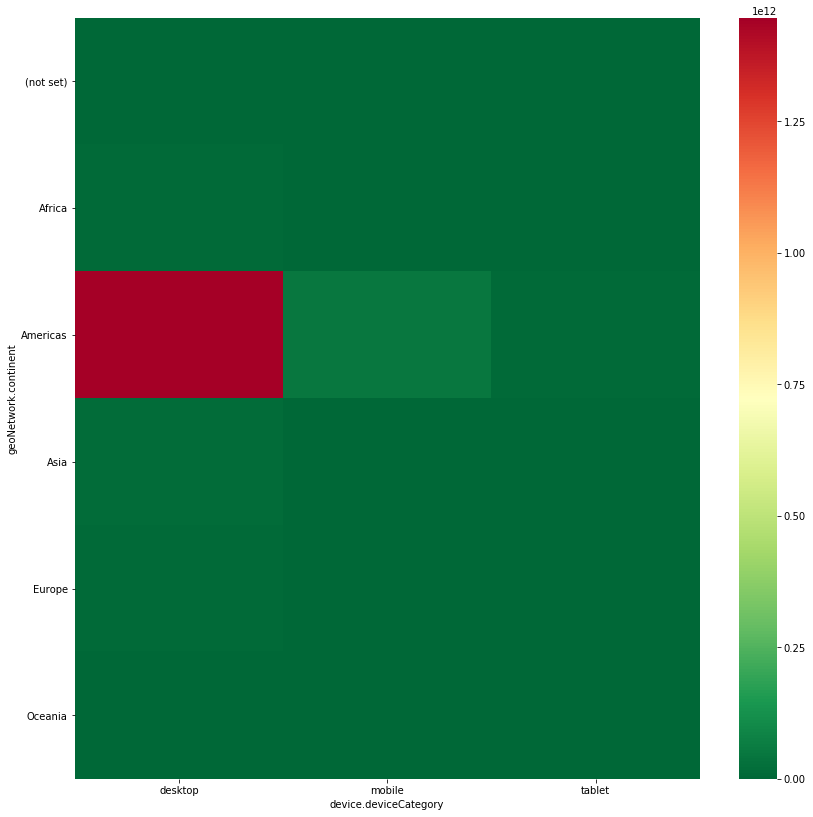

In [33]:
import matplotlib.pyplot as plt
df = pd.DataFrame(matrix, index=matrix.index,
               columns=matrix.columns)
sns.heatmap(df, cmap='RdYlGn_r')
plt.gcf().set_size_inches(14,14)
plt.show()

## Q3 Cluster the data based on geographic information available with a subset of variables that you find relevant.  Include a visualization plot.  Describe your inferences from the clustering and discuss their significance.

In [85]:
geo_cols = train_data.columns[train_data.columns.str.contains('geoNetwork')].T.tolist()
print("There are ",len(geo_cols),"columns with geoNetwork attributes:\n",geo_cols)

There are  7 columns with geoNetwork attributes:
 ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent']


In [86]:
const_geo_cols = []
for i, col in enumerate(geo_cols):
    if(len(train_data[col].value_counts())==1):
        const_geo_cols.append(col)
print("There are ",len(const_geo_cols),"columns with unique value for geoNetwork attributes:\n",const_geo_cols)

There are  0 columns with unique value for geoNetwork attributes:
 []


In [87]:
def show_features(data,features,width=6,height=6):
    for i,feature in enumerate(features):
        f, ax = plt.subplots(1,1, figsize=(width,height))
        sns.countplot(data[feature],order = data[feature].value_counts().iloc[:50].index)
        plt.xticks(rotation=90)
        plt.show()

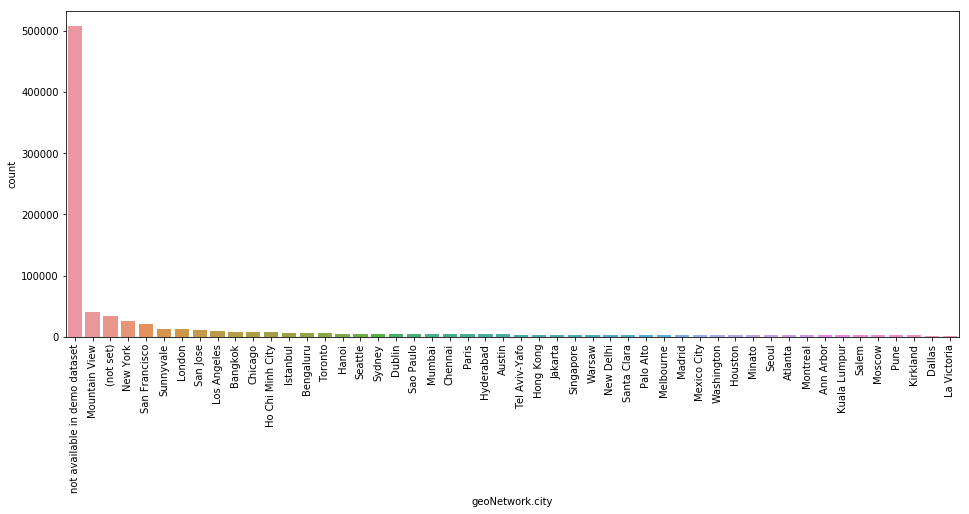

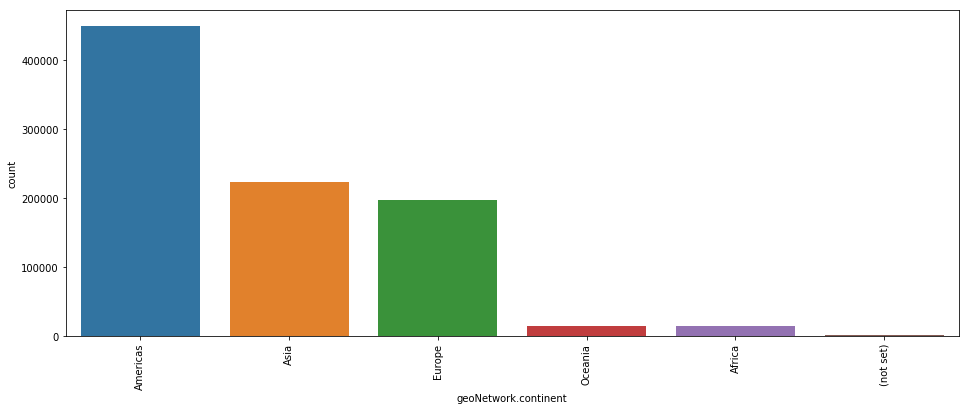

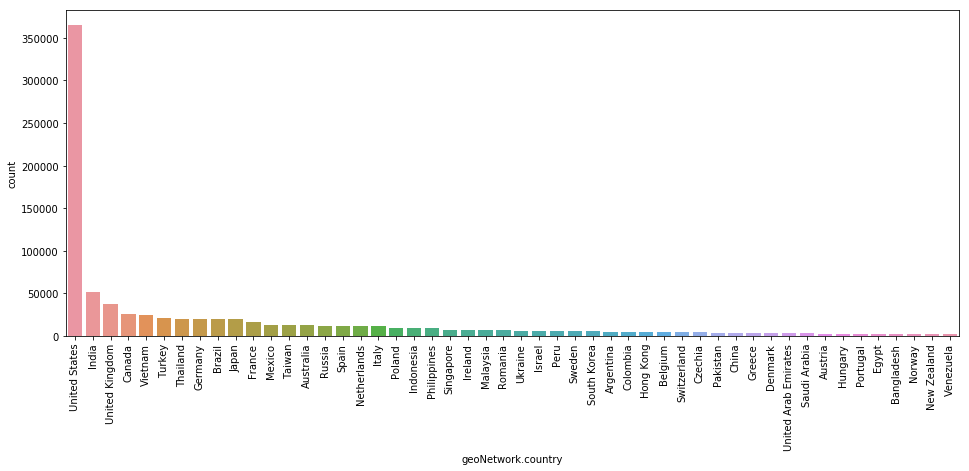

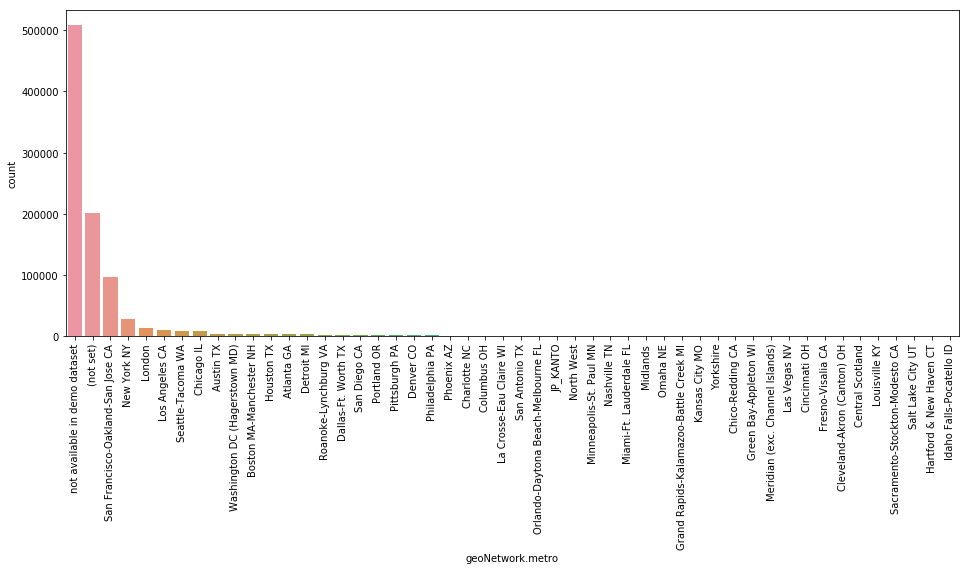

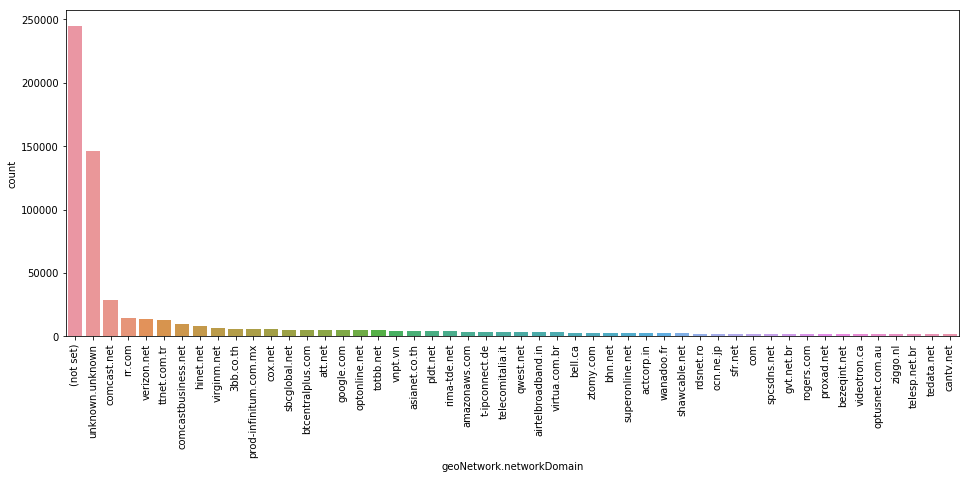

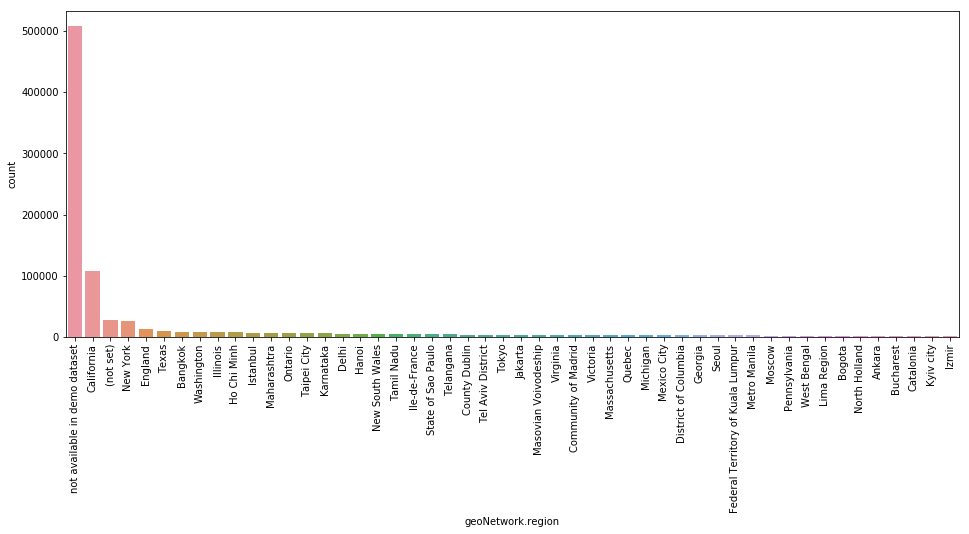

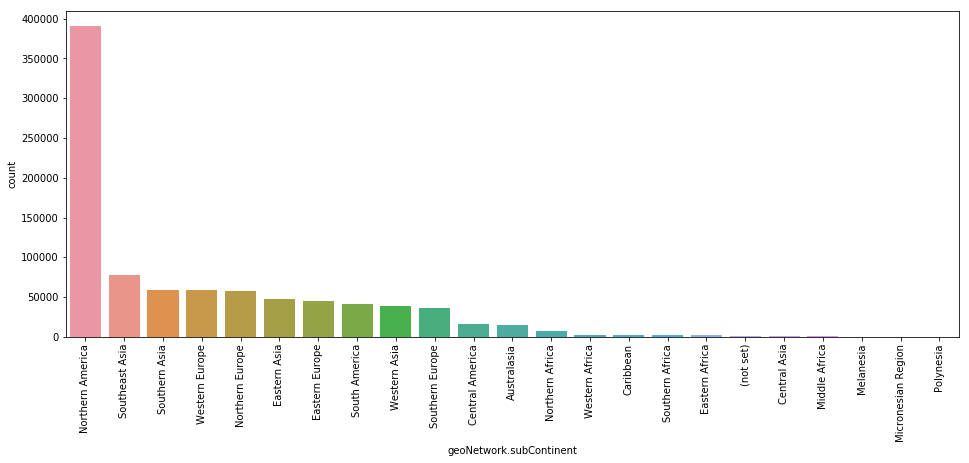

In [88]:
show_features(train_data,geo_cols,16,6)

In [89]:
tot_cols = train_data.columns[train_data.columns.str.contains('totals')].T.tolist()
print("There are ",len(tot_cols),"columns with Totals attributes:\n",tot_cols)

There are  5 columns with Totals attributes:
 ['totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue']


Let's check if there are columns with an unique value.

In [90]:
def check_unique_totals(train_data):
    const_tot_cols = []
    for i, col in enumerate(tot_cols):
        if(len(train_data[col].unique())==1):
            const_tot_cols.append(col)
    print("There are ",len(const_tot_cols),"columns with unique value for Totals attributes:\n",const_tot_cols)

In [91]:
check_unique_totals(train_data)

There are  0 columns with unique value for Totals attributes:
 []


In [92]:
tot_cols.remove('totals.transactionRevenue')

In [93]:
check_unique_totals(test_data)

There are  0 columns with unique value for Totals attributes:
 []


In [94]:
device_cols = train_data.columns[train_data.columns.str.contains('device')].T.tolist()
print("There are ",len(device_cols),"columns with device attributes:\n",device_cols)

There are  4 columns with device attributes:
 ['device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem']


In [95]:
const_device_cols = []
for i, col in enumerate(device_cols):
    if(len(train_data[col].value_counts())==1):
        const_device_cols.append(col)
print("There are ",len(const_device_cols),"columns with unique value for device attributes:\n",const_device_cols)

There are  0 columns with unique value for device attributes:
 []


In [96]:
train_data.shape

(903653, 33)

In [97]:
tot_cols = train_data.columns[train_data.columns.str.contains('totals')].T.tolist()
print("There are ",len(tot_cols),"columns with Totals attributes:\n",tot_cols)

There are  5 columns with Totals attributes:
 ['totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue']


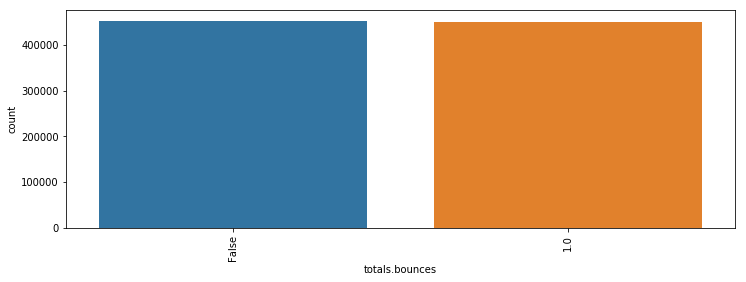

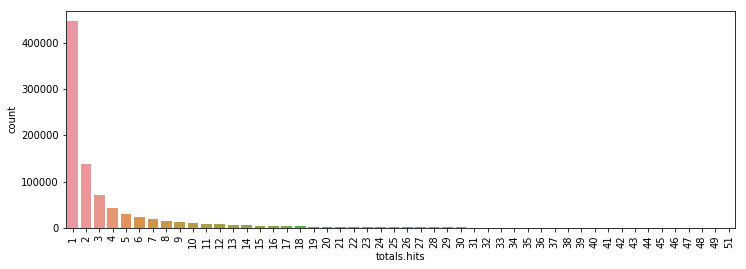

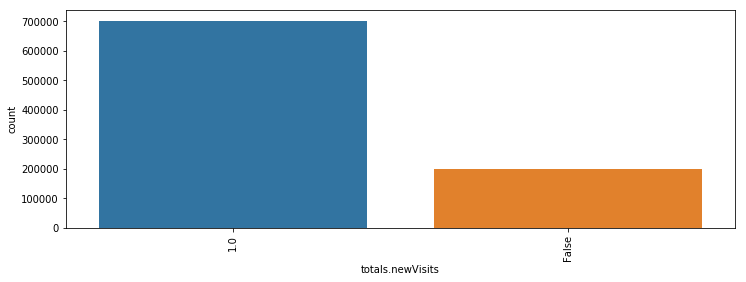

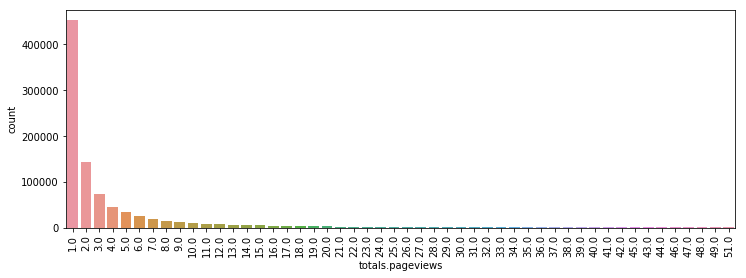

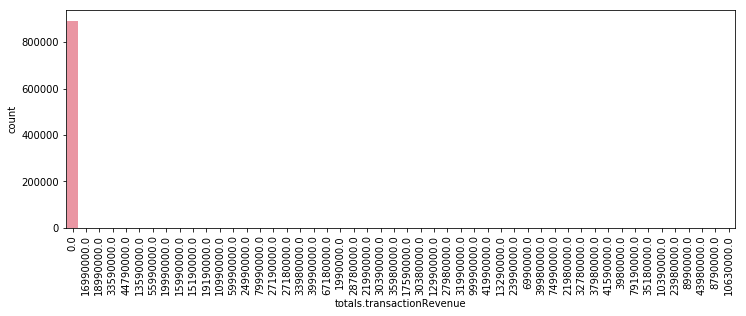

In [98]:
show_features(train_data,tot_cols,12,4)

In [99]:
train_data['totals.transactionRevenue'] = pd.to_numeric(train_data['totals.transactionRevenue'])
df = train_data[train_data['totals.transactionRevenue'] > 0]['totals.transactionRevenue']

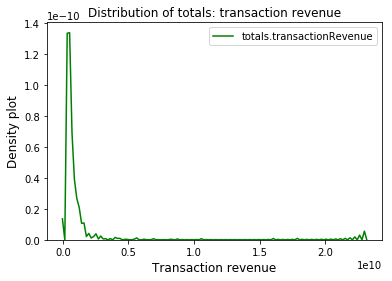

In [100]:
plt.title("Distribution of totals: transaction revenue")
sns.kdeplot(df, color="green")
plt.ylabel('Density plot', fontsize=12)
plt.xlabel('Transaction revenue', fontsize=12)
plt.show()

The density plot looks sweked, lets plot the log of the revenue.

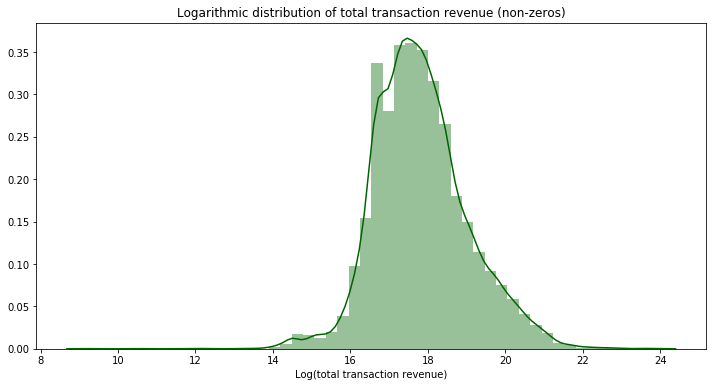

In [101]:
plt.figure(figsize=(12,6))
sns.distplot(np.log1p(df),color="darkgreen",bins=50)
plt.xlabel("Log(total transaction revenue)");
plt.title("Logarithmic distribution of total transaction revenue (non-zeros)");

In [102]:
# select the visits with non-zero transaction revenue
non_zero = train_data[train_data['totals.transactionRevenue']>0]
tmp = non_zero['geoNetwork.country'].value_counts()
country_visits = pd.DataFrame(data={'geoNetwork.country': tmp.values}, index=tmp.index).reset_index()
country_visits.columns = ['Country', 'Visits']

In [103]:
train_data.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.referralPath',
       'trafficSource.source', 'year', 'month', 'day', 'weekday'],
      dtype='object')

In [105]:
def makeFloat(train_data):
    for col in ['visitNumber', 'totals.hits', 'trafficSource.adwordsClickInfo.page','totals.bounces', 
                'totals.pageviews', 'totals.newVisits']:
        train_data[col] = train_data[col].astype(float)
        train_data['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
        train_data['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [106]:
makeFloat(train_data)

In [107]:
makeFloat(test_data)

## Making custom features before Building The model

In [108]:
train_data['browser_category'] = train_data['device.browser'] + '_' + train_data['device.deviceCategory']
train_data['browser_os'] = train_data['device.browser'] + '_' + train_data['device.operatingSystem']
train_data['category_os'] = train_data['device.deviceCategory'] + '_' + train_data['device.operatingSystem']

In [109]:
test_data['browser_category'] = test_data['device.browser'] + '_' + test_data['device.deviceCategory']
test_data['browser_os'] = test_data['device.browser'] + '_' + test_data['device.operatingSystem']
test_data['category_os'] = test_data['device.deviceCategory'] + '_' + test_data['device.operatingSystem']

Accessing the popularity of the browsers, using mean-

In [110]:
train_data['visits_id_browser_mean'] = np.log1p(train_data.groupby(['device.browser'])['visitNumber'].transform('mean'))
train_data['visits_id_os_mean'] = np.log1p(train_data.groupby(['device.operatingSystem'])['visitNumber'].transform('mean'))
train_data['visits_id_cat_mean'] = np.log1p(train_data.groupby(['device.deviceCategory'])['visitNumber'].transform('mean'))
train_data['browser_unique_user_count'] = train_data.groupby('device.browser')['fullVisitorId'].transform('nunique')
train_data['os_unique_user_count'] = train_data.groupby('device.operatingSystem')['fullVisitorId'].transform('nunique')

In [111]:
test_data['visits_id_browser_mean'] = np.log1p(test_data.groupby(['device.browser'])['visitNumber'].transform('mean'))
test_data['visits_id_os_mean'] = np.log1p(test_data.groupby(['device.operatingSystem'])['visitNumber'].transform('mean'))
test_data['visits_id_cat_mean'] = np.log1p(test_data.groupby(['device.deviceCategory'])['visitNumber'].transform('mean'))
test_data['browser_unique_user_count'] = test_data.groupby('device.browser')['fullVisitorId'].transform('nunique')
test_data['os_unique_user_count'] = test_data.groupby('device.operatingSystem')['fullVisitorId'].transform('nunique')

In [112]:
train_data['visits_id_mean'] = train_data.groupby(['fullVisitorId'])['visitNumber'].transform('mean')
train_data['totals.pageviews'] = train_data['totals.pageviews'].fillna(0)
train_data['mean_hits_per_day'] = train_data.groupby(['day'])['totals.hits'].transform('mean')
train_data['mean_pageviews_per_day'] = train_data.groupby(['day'])['totals.pageviews'].transform('mean')

In [113]:
test_data['visits_id_mean'] = test_data.groupby(['fullVisitorId'])['visitNumber'].transform('mean')
test_data['totals.pageviews'] = test_data['totals.pageviews'].fillna(0)
test_data['mean_hits_per_day'] = test_data.groupby(['day'])['totals.hits'].transform('mean')
test_data['mean_pageviews_per_day'] = test_data.groupby(['day'])['totals.pageviews'].transform('mean')

## Grouping Geo Features by visitorId and getting Mean

In [114]:
train_data['mean_visit_per_network_domain']= train_data.groupby('geoNetwork.networkDomain')['visitNumber'].transform('mean')
train_data['mean_pageviews_per_network_domain'] = train_data.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')
train_data['mean_hits_per_network_domain'] = train_data.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')

In [115]:
test_data['mean_visit_per_network_domain']= test_data.groupby('geoNetwork.networkDomain')['visitNumber'].transform('mean')
test_data['mean_pageviews_per_network_domain'] = test_data.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')
test_data['mean_hits_per_network_domain'] = test_data.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')

## Grouping Traffic Source Features by visitorId and getting Mean

In [116]:
def custom_func(train_data):
    train_data['source_country'] = train_data['trafficSource.source'] + '_' + train_data['geoNetwork.country']
    train_data['campaign_country'] = train_data['trafficSource.campaign'] + '_' + train_data['geoNetwork.country']
    

In [117]:
custom_func(train_data)

In [118]:
custom_func(test_data)

## Drop Columns which have unique values-

In [119]:
cols_to_drop = [col for col in train_data.columns if train_data[col].nunique(dropna=False)== 1]

In [120]:
print(cols_to_drop)

[]


In [121]:
def drop_convert_columns(train_data=None, test_df=None):
    cols_to_drop = [col for col in train_data.columns if train_data[col].nunique(dropna=False) == 1]
    train_data.drop(cols_to_drop, axis=1, inplace=True)
    test_data.drop([col for col in cols_to_drop if col in test_data.columns], axis=1, inplace=True)
    ###converting columns format
    train_data['totals.transactionRevenue'] = train_data['totals.transactionRevenue'].astype(float)
    train_data['totals.transactionRevenue'] = train_data['totals.transactionRevenue'].fillna(0)
    train_data['totals.transactionRevenue'] = np.log1p(train_data['totals.transactionRevenue'])
    return train_data, test_data

In [122]:
drop_convert_columns(train_data,test_data)

(       channelGrouping       date        fullVisitorId  \
 0       Organic Search 2016-09-02  1131660440785968503   
 1       Organic Search 2016-09-02   377306020877927890   
 2       Organic Search 2016-09-02  3895546263509774583   
 3       Organic Search 2016-09-02  4763447161404445595   
 4       Organic Search 2016-09-02    27294437909732085   
 5       Organic Search 2016-09-02  2938943183656635653   
 6       Organic Search 2016-09-02  1905672039242460897   
 7       Organic Search 2016-09-02   537222803633850821   
 8       Organic Search 2016-09-02  4445454811831400414   
 9       Organic Search 2016-09-02  9499785259412240342   
 10      Organic Search 2016-09-02  0523069750702990437   
 11      Organic Search 2016-09-02   982320996976275749   
 12      Organic Search 2016-09-02   357659889600827884   
 13      Organic Search 2016-09-02  1438082600262726746   
 14      Organic Search 2016-09-02  3531015320757710684   
 15      Organic Search 2016-09-02  9638207207743070032 

In [123]:
train_data.dtypes

channelGrouping                                     object
date                                        datetime64[ns]
fullVisitorId                                       object
sessionId                                           object
visitId                                              int64
visitNumber                                        float64
visitStartTime                                       int64
device.browser                                      object
device.deviceCategory                               object
device.isMobile                                       bool
device.operatingSystem                              object
geoNetwork.city                                     object
geoNetwork.continent                                object
geoNetwork.country                                  object
geoNetwork.metro                                    object
geoNetwork.networkDomain                            object
geoNetwork.region                                   obje

In [5]:
object_cols = [col for col in train_data.columns if train_data[col].dtype == object]

In [6]:
print(object_cols)

['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.campaign', 'trafficSource.referralPath', 'trafficSource.source', 'browser_category', 'browser_os', 'category_os', 'source_country', 'campaign_country']


In [7]:
not_used_cols = ["date", "fullVisitorId", "sessionId", 
            "visitId", "visitStartTime", 'totals.transactionRevenue', 'trafficSource.referralPath']

In [8]:
cat_cols = [col for col in object_cols if col not in not_used_cols]

In [9]:
print(cat_cols)

['channelGrouping', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.campaign', 'trafficSource.source', 'browser_category', 'browser_os', 'category_os', 'source_country', 'campaign_country']


In [10]:
len(cat_cols)

18

## Pesrsisting the final set of features into a csv file

In [11]:
len(test_data.columns)

48

In [12]:
len(train_data.columns)

49

In [132]:
for col in train_data:
    if col not in test_data:
        print(col)

totals.transactionRevenue


In [133]:
train_data.to_csv('../hw3_data/final_features_train.csv', mode='w', index=False)

In [134]:
test_data.to_csv('../hw3_data/final_features_test.csv', mode='w', index=False)

In [29]:
train_data = pd.read_csv('../hw3_data/final_features_train.csv', low_memory=False)

In [30]:
test_data = pd.read_csv('../hw3_data/final_features_test.csv', low_memory=False)

## There are 18 Categorical columns, lets encode them.

In [114]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train_data[col].values.astype('str')) + list(test_data[col].values.astype('str')))
    train_data[col] = lbl.transform(list(train_data[col].values.astype('str')))
    test_data[col] = lbl.transform(list(test_data[col].values.astype('str')))

In [115]:
not_useful_cat_cols = ['geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.city' ]

In [116]:
train_data.drop(not_useful_cat_cols, axis=1, inplace=True)

In [117]:
test_data.drop(not_useful_cat_cols, axis=1, inplace=True)

In [118]:
train_data.to_csv('../hw3_data/final_features_labelencoded_train.csv', mode='w', index=False)

In [18]:
test_data.to_csv('../hw3_data/final_features_labelencoded_test.csv', mode='w', index=False)

## Q4) Finally, Applying models to the data

In [53]:
total_visits = train_data.groupby('fullVisitorId')[['visitNumber']].sum().sort_values(by='visitNumber', ascending=False)

In [54]:
visitors = total_visits.iloc[:10].index

In [55]:
visitors

Index(['0824839726118485274', '1957458976293878100', '3608475193341679870',
       '1856749147915772585', '7634897085866546110', '3269834865385146569',
       '4913801338365738862', '2082625651279391786', '0720311197761340948',
       '0232377434237234751'],
      dtype='object', name='fullVisitorId')

In [58]:
visitor_revenue = {}
for index, row in train_data.iterrows():
    if row['fullVisitorId'] in visitors:
        if row['fullVisitorId'] not in visitor_revenue:
            visitor_revenue[row['fullVisitorId']] = 0
        visitor_revenue[row['fullVisitorId']] += row['totals.transactionRevenue']

In [59]:
visitor_revenue

{'0232377434237234751': 16.7047706426251,
 '0720311197761340948': 0.0,
 '0824839726118485274': 0.0,
 '1856749147915772585': 0.0,
 '1957458976293878100': 336.6193365443671,
 '2082625651279391786': 0.0,
 '3269834865385146569': 19.007911704479405,
 '3608475193341679870': 16.971659595513607,
 '4913801338365738862': 0.0,
 '7634897085866546110': 17.034386422832473}

In [35]:
train_data.nlargest(10, 'total_visits_per_user')[['fullVisitorId', 'totals.transactionRevenue']]

,fullVisitorId,totals.transactionRevenue


In [52]:
train_data = pd.read_csv('../hw3_data/final_features_labelencoded_train.csv', low_memory=False)
test_data = pd.read_csv('../hw3_data/final_features_labelencoded_test.csv', low_memory=False)

In [156]:
len(train_data.columns)

45

In [157]:
len(test_data.columns)

44

In [158]:
train_data = train_data.sort_values('date')
X_test = test_data.drop([col for col in not_used_cols if col in test_data.columns], axis=1) 

In [190]:
cols_in_model = ['browser_category', 'browser_os', 'category_os', 'channelGrouping', 'geoNetwork.continent', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'year', 'month']

In [207]:
del [X_train]

In [211]:
X_train = pd.DataFrame()

In [212]:
for col in cols_in_model:
    X_train[col] = train_data[col]

In [213]:
X_train.dtypes

browser_category             int64
browser_os                   int64
category_os                  int64
channelGrouping              int64
geoNetwork.continent         int64
geoNetwork.subContinent      int64
totals.bounces             float64
totals.hits                float64
totals.newVisits           float64
totals.pageviews           float64
year                         int64
month                        int64
dtype: object

##Q4 Define a buying score or probability function for each user, which predicts the likelihood of a user buying a product from the GStore. Rank the ten most likely users as who will buy a product from the store. 

In [214]:
train_data['positive_revenue'] = train_data['totals.transactionRevenue'].apply(lambda x : 0.0 if x <= 0 else 1)

In [215]:
train_data['positive_revenue'].describe()

count    903653.000000
mean          0.012743
std           0.112162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: positive_revenue, dtype: float64

In [216]:
missing_data(X_train)

,Total,Percent


In [217]:
missing_data(X_test)

,Total,Percent


In [218]:
y_train = train_data['positive_revenue']

In [219]:
X_train.shape

(903653, 12)

In [220]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [221]:
prob_arr_train = logreg.predict_proba(X_train)
df_prob = pd.DataFrame(prob_arr_train)

In [222]:
train_data['pos_rev_prob'] = df_prob[1]
train_data['neg_rev_prob'] = df_prob[0]

In [239]:
list1 = train_data.nlargest(10, 'totals.transactionRevenue')[['fullVisitorId', 'totals.transactionRevenue', 'pos_rev_prob', 'neg_rev_prob', 'positive_revenue']]

In [240]:
list1

,fullVisitorId,totals.transactionRevenue,pos_rev_prob,neg_rev_prob,positive_revenue
375253,1957458976293878100,23.864375,0.001892,0.998108,1.0
430822,1957458976293878100,23.605577,0.028723,0.971277,1.0
380988,5632276788326171571,23.497338,0.011110,0.988890,1.0
773715,9417857471295131045,23.083095,0.000531,0.999469,1.0
891576,1957458976293878100,22.884037,0.000996,0.999004,1.0
715264,4471415710206918415,22.833334,0.000279,0.999721,1.0
629767,7496147812697146114,22.668676,0.010336,0.989664,1.0
843293,1957458976293878100,22.644145,0.009208,0.990792,1.0
572866,79204932396995037,22.555647,0.000074,0.999926,1.0
799542,1957458976293878100,22.448608,0.005940,0.994060,1.0


In [241]:
list2 = train_data.nsmallest(10, 'totals.transactionRevenue')[['fullVisitorId', 'totals.transactionRevenue', 'pos_rev_prob', 'neg_rev_prob', 'positive_revenue']]

In [242]:
list2

,fullVisitorId,totals.transactionRevenue,pos_rev_prob,neg_rev_prob,positive_revenue
538448,1492602573213666603,0.0,0.001152,0.998848,0.0
538277,7394165545362887055,0.0,0.000563,0.999437,0.0
538278,6107229716178617930,0.0,0.006492,0.993508,0.0
538279,9459384188253198762,0.0,0.000215,0.999785,0.0
538280,4052177266351383392,0.0,0.007729,0.992271,0.0
538281,9066503657481474837,0.0,0.001064,0.998936,0.0
538282,8842322787175138234,0.0,0.000274,0.999726,0.0
538283,5874622223792422534,0.0,0.027892,0.972108,0.0
538284,4652287826732444235,0.0,0.006308,0.993692,0.0
538285,079785550312480399,0.0,0.001629,0.998371,0.0


These probabilities work as the buying score  predicts the likelihood of a user buying a product from the GStore.
The array has 2 probabilities for each 

## Q5 External Dataset
Kaggle Link - https://www.kaggle.com/aehsaei/internet-users-per-100-people
Internet User Dataset.csv
It has the number of people with internet access per 100 people for a country from 1960 to 2015.
We will just take data of 2015 here.

## The spread of year in the train data is from 2016-2017. We will just match countries in train data with countries in external datset

In [133]:
train_data['year'].describe()

count    903653.000000
mean       2016.517079
std           0.499708
min        2016.000000
25%        2016.000000
50%        2017.000000
75%        2017.000000
max        2017.000000
Name: year, dtype: float64

In [76]:
list_countries = train_data['geoNetwork.country'].unique().tolist()
len(list_countries)

222

In [77]:
list_countries

['Turkey',
 'Australia',
 'Spain',
 'Indonesia',
 'United Kingdom',
 'Italy',
 'Pakistan',
 'Austria',
 'Netherlands',
 'India',
 'France',
 'Brazil',
 'China',
 'Singapore',
 'Argentina',
 'Poland',
 'Germany',
 'Canada',
 'Thailand',
 'Hungary',
 'Malaysia',
 'Denmark',
 'Taiwan',
 'Russia',
 'Nigeria',
 'Belgium',
 'South Korea',
 'Chile',
 'Ireland',
 'Philippines',
 'Greece',
 'Mexico',
 'Montenegro',
 'United States',
 'Bangladesh',
 'Japan',
 'Slovenia',
 'Czechia',
 'Sweden',
 'United Arab Emirates',
 'Switzerland',
 'Portugal',
 'Peru',
 'Hong Kong',
 'Vietnam',
 'Sri Lanka',
 'Serbia',
 'Norway',
 'Romania',
 'Kenya',
 'Ukraine',
 'Israel',
 'Slovakia',
 '(not set)',
 'Lithuania',
 'Puerto Rico',
 'Bosnia & Herzegovina',
 'Croatia',
 'South Africa',
 'Paraguay',
 'Botswana',
 'Colombia',
 'Uruguay',
 'Algeria',
 'Finland',
 'Guatemala',
 'Egypt',
 'Malta',
 'Bulgaria',
 'New Zealand',
 'Kuwait',
 'Uzbekistan',
 'Saudi Arabia',
 'Cyprus',
 'Estonia',
 'Côte d’Ivoire',
 'Morocc

## The external dataset has 269 countries which covers the breadth of our dataset.

In [68]:
external_data = pd.read_csv('../hw3_data/InternetUsersDataset.csv', low_memory=False)

In [69]:
external_data = external_data[['Country Name', '2015']]

In [70]:
country_user = {}
for index, row in external_data.iterrows():
    key = row['Country Name']
    value = row['2015']
    country_user[key] = value

In [71]:
external_data

,Country Name,2015
0,Aruba,88.661227
1,Andorra,96.910000
2,Afghanistan,8.260000
3,Angola,12.400000
4,Albania,63.252933
5,Arab World,39.526154
6,United Arab Emirates,91.243406
7,Argentina,69.400921
8,Armenia,58.249332
9,American Samoa,NaN


In [72]:
country_user

{'Afghanistan': 8.26,
 'Albania': 63.2529327,
 'Algeria': 38.2,
 'American Samoa': nan,
 'Andorra': 96.91,
 'Angola': 12.4,
 'Antigua and Barbuda': 65.2,
 'Arab World': 39.52615407,
 'Argentina': 69.40092102,
 'Armenia': 58.24933222,
 'Aruba': 88.66122693,
 'Australia': 84.56051935,
 'Austria': 83.9263,
 'Azerbaijan': 77.0,
 'Bahamas, The': 78.0,
 'Bahrain': 93.47830114,
 'Bangladesh': 14.4,
 'Barbados': 76.11,
 'Belarus': 62.23036091,
 'Belgium': 85.0529,
 'Belize': 41.59,
 'Benin': 6.787702956,
 'Bermuda': 98.32360965,
 'Bhutan': 39.8,
 'Bolivia': 45.1,
 'Bosnia and Herzegovina': 65.06550279999999,
 'Botswana': 27.5,
 'Brazil': 59.07947791,
 'British Virgin Islands': nan,
 'Brunei Darussalam': 71.2,
 'Bulgaria': 56.6563,
 'Burkina Faso': 11.38764617,
 'Burundi': 4.866224464,
 'Cabo Verde': 43.01962636,
 'Cambodia': 19.0,
 'Cameroon': 20.68014766,
 'Canada': 88.47,
 'Caribbean small states': 51.91699952,
 'Cayman Islands': 77.0,
 'Central African Republic': 4.563264352,
 'Central Euro

In [73]:
list_countries_external = external_data['Country Name'].tolist()

In [74]:
list_countries_external

['Aruba',
 'Andorra',
 'Afghanistan',
 'Angola',
 'Albania',
 'Arab World',
 'United Arab Emirates',
 'Argentina',
 'Armenia',
 'American Samoa',
 'Antigua and Barbuda',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Burundi',
 'Belgium',
 'Benin',
 'Burkina Faso',
 'Bangladesh',
 'Bulgaria',
 'Bahrain',
 'Bahamas, The',
 'Bosnia and Herzegovina',
 'Belarus',
 'Belize',
 'Bermuda',
 'Bolivia',
 'Brazil',
 'Barbados',
 'Brunei Darussalam',
 'Bhutan',
 'Botswana',
 'Central African Republic',
 'Canada',
 'Central Europe and the Baltics',
 'Switzerland',
 'Channel Islands',
 'Chile',
 'China',
 "Cote d'Ivoire",
 'Cameroon',
 'Congo, Rep.',
 'Colombia',
 'Comoros',
 'Cabo Verde',
 'Costa Rica',
 'Caribbean small states',
 'Cuba',
 'Curacao',
 'Cayman Islands',
 'Cyprus',
 'Czech Republic',
 'Germany',
 'Djibouti',
 'Dominica',
 'Denmark',
 'Dominican Republic',
 'Algeria',
 'East Asia & Pacific (excluding high income)',
 'Early-demographic dividend',
 'East Asia & Pacific',
 'Europe & Central 

In [78]:
for country in list_countries:
    if country not in list_countries_external:
        print(country)

Taiwan
Russia
South Korea
Czechia
Hong Kong
Slovakia
(not set)
Bosnia & Herzegovina
Egypt
Côte d’Ivoire
Venezuela
Cape Verde
Macedonia (FYROM)
Laos
Myanmar (Burma)
Turks & Caicos Islands
Gambia
Trinidad & Tobago
Palestine
Réunion
St. Kitts & Nevis
Congo - Kinshasa
Kyrgyzstan
Yemen
French Guiana
Macau
Guadeloupe
Martinique
Brunei
Iran
Curaçao
Guernsey
Antigua & Barbuda
Sint Maarten
St. Vincent & Grenadines
Jersey
U.S. Virgin Islands
Mayotte
Norfolk Island
Bahamas
Åland Islands
St. Pierre & Miquelon
Syria
Cook Islands
Anguilla
Caribbean Netherlands
Congo - Brazzaville
St. Martin
São Tomé & Príncipe
St. Barthélemy


In [79]:
country_dict={}

In [80]:
country_dict['Caribbean Netherlands'] = 'Latin America & Caribbean (excluding high income)'
country_dict['Bahamas'] = 'Latin America & Caribbean (excluding high income)'
country_dict['St. Vincent & Grenadines'] = 'Latin America & Caribbean (excluding high income)'
country_dict['Antigua & Barbuda'] = 'Latin America & Caribbean (excluding high income)'
country_dict['St. Vincent & Grenadines'] = 'St. Vincent and the Grenadines'
country_dict['Caribbean Netherlands'] = 'Latin America & Caribbean (excluding high income)'
country_dict['Russia']= 'Russian Federation'
country_dict['Iran'] = 'Iran, Islamic Rep.'
country_dict['Trinidad & Tobago'] = 'Trinidad and Tobago' 
country_dict['Egypt'] = 'Egypt, Arab Rep.'
country_dict['Hong Kong'] = 'Hong Kong SAR, China'
country_dict['South Korea'] = 'East Asia & Pacific (IDA & IBRD countries)'
country_dict['Taiwan'] = 'East Asia & Pacific (IDA & IBRD countries)'
country_dict['Myanmar (Burma)'] = 'Myanmar'

In [81]:
def get_users(country):
    if country not in list_countries_external and country not in country_dict:
        return 0.0
    if country in country_dict:
        country = country_dict[country]
    return country_user[country]   
    '''
    for index, row in external_data.iterrows():
            if row['Country Name']==country:
                return external_data['2015'].loc[index]
    '''

In [82]:
print(get_users('Iran'))

44.08287502


In [83]:
train_data['internet_users'] = train_data.apply(lambda row: get_users(row['geoNetwork.country']), axis=1)

In [84]:
test_data['internet_users'] = test_data.apply(lambda row: get_users(row['geoNetwork.country']), axis=1)

In [150]:
train_data['internet_users'].dtype

dtype('float64')

## Q6) Now Apply the modeling but also make sure that categorical columns are converted to numeric

In [57]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train_data[col].values.astype('str')) + list(test_data[col].values.astype('str')))
    train_data[col] = lbl.transform(list(train_data[col].values.astype('str')))
    test_data[col] = lbl.transform(list(test_data[col].values.astype('str')))

In [58]:
not_useful_cat_cols = ['geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.city' ]
train_data.drop(not_useful_cat_cols, axis=1, inplace=True)
test_data.drop(not_useful_cat_cols, axis=1, inplace=True)

In [70]:
X_test = test_data.drop([col for col in not_used_cols if col in test_data.columns], axis=1)

In [94]:
## Model parameters
params = {
    "objective" : "regression",
    "metric" : "rmse", 
    "num_leaves" : 30,
    "min_child_samples" : 100,
    "learning_rate" : 0.1,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.5,
    "bagging_frequency" : 5,
    "bagging_seed" : 20180926,
    "verbosity" : -1
}

## Hyper parameters

In [95]:
NUM_ROUNDS = 20000
VERBOSE_EVAL = 250
STOP_ROUNDS = 250
N_SPLITS = 10

In [96]:
y = train_data['totals.transactionRevenue']
y.describe()

count    903653.000000
mean          0.227118
std           2.003710
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.864375
Name: totals.transactionRevenue, dtype: float64

## Choose either one of the models

## 1.LGBM

In [97]:
model = lgb.LGBMRegressor(**params, n_estimators = NUM_ROUNDS, nthread = 4, n_jobs = -1)

## 2. Random Forest

In [77]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

## 3. XGBoost

In [65]:
import xgboost
model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

## Common Code from below-

In [63]:
prediction = np.zeros(test_data.shape[0])

## Choose one of the predict functions based on the chosen model.

In [92]:
def predict(train_data):
    X = train_data.drop(not_used_cols, axis=1)
    y = train_data['totals.transactionRevenue']
    folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=20180917)
    prediction = np.zeros(test_data.shape[0])
    for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
        print(fold_n)
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                verbose=VERBOSE_EVAL, early_stopping_rounds=STOP_ROUNDS)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        prediction += y_pred

    prediction /= N_SPLITS    
    return prediction

In [79]:
def predict_randomforest(train_data):
    X = train_data.drop(not_used_cols, axis=1)
    y = train_data['totals.transactionRevenue']
    folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=20180917)
    prediction = np.zeros(test_data.shape[0])
    for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
        print(fold_n)
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        y_pred =  model.predict(X_test)
        prediction += y_pred

    prediction /= N_SPLITS    
    return prediction

In [80]:
def predict_xgboost(train_data):
    X = train_data.drop(not_used_cols, axis=1)
    y = train_data['totals.transactionRevenue']
    folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=20180917)
    prediction = np.zeros(test_data.shape[0])
    for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
        print(fold_n)
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        y_pred =  model.predict(X_test)
        prediction += y_pred

    prediction /= N_SPLITS    
    return prediction

In [69]:
predictions = predict_xgboost(train_data)

0
1
2
3
4
5
6
7
8
9


In [71]:
predictions = predict(train_data)

0
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.5453	valid_1's rmse: 1.61758
[500]	training's rmse: 1.49645	valid_1's rmse: 1.6213
Early stopping, best iteration is:
[278]	training's rmse: 1.53885	valid_1's rmse: 1.61706
1
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.54602	valid_1's rmse: 1.60567
[500]	training's rmse: 1.49594	valid_1's rmse: 1.60522
Early stopping, best iteration is:
[345]	training's rmse: 1.52462	valid_1's rmse: 1.60388
2
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.54888	valid_1's rmse: 1.58819
[500]	training's rmse: 1.49986	valid_1's rmse: 1.58597
Early stopping, best iteration is:
[466]	training's rmse: 1.50503	valid_1's rmse: 1.58529
3
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.54389	valid_1's rmse: 1.63421
[500]	training's rmse: 1.49378	valid_1's rmse: 1.63536
Early stopping, best iteration i

In [70]:
xgboost_predictions = predictions

## Trying a model with few choosen features

In [66]:
cols_in_model = ['source_country', 'campaign_country', 'browser_os', 'category_os', 'channelGrouping', 'geoNetwork.country', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'year', 'month', 'internet_users']

In [65]:
train_data = pd.read_csv('../hw3_data/final_features_train.csv', low_memory = False)
test_data = pd.read_csv('../hw3_data/final_features_test.csv', low_memory = False)

In [85]:
train_data['internet_users'] = train_data.apply(lambda row: get_users(row['geoNetwork.country']), axis=1)
test_data['internet_users'] = test_data.apply(lambda row: get_users(row['geoNetwork.country']), axis=1)

In [119]:
train_small = pd.DataFrame()
test_small = pd.DataFrame()
for col in cols_in_model:
    train_small[col] = train_data[col]
    test_small[col] =  test_data[col]

In [120]:
train_small.describe()

,source_country,campaign_country,browser_os,category_os,channelGrouping,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,year,month,internet_users
count,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903183.000000
mean,2294.069342,199.844981,65.691891,13.368476,4.632267,13.310106,0.498676,4.596538,0.778020,3.849338,2016.517079,6.987671,67.428477
std,1426.922480,120.783830,39.574723,9.300808,1.774791,4.678611,0.499999,9.641437,0.415578,7.025002,0.499708,3.484576,20.285533
min,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2016.000000,1.000000,0.000000
25%,1838.000000,116.000000,42.000000,5.000000,4.000000,12.000000,0.000000,1.000000,1.000000,1.000000,2016.000000,4.000000,57.431043
50%,2012.000000,227.000000,45.000000,13.000000,4.000000,12.000000,0.000000,2.000000,1.000000,1.000000,2017.000000,7.000000,74.550000
75%,3412.000000,235.000000,74.000000,17.000000,7.000000,16.000000,1.000000,4.000000,1.000000,4.000000,2017.000000,10.000000,74.550000
max,4478.000000,982.000000,202.000000,42.000000,7.000000,22.000000,1.000000,500.000000,1.000000,469.000000,2017.000000,12.000000,98.323610


In [88]:
cat_cols = ['source_country', 'campaign_country', 'browser_os', 'category_os', 'channelGrouping', 'geoNetwork.subContinent', ]

In [89]:
train_small.describe()

,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,year,month,internet_users
count,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903183.000000
mean,0.498676,4.596538,0.778020,3.849338,2016.517079,6.987671,67.428477
std,0.499999,9.641437,0.415578,7.025002,0.499708,3.484576,20.285533
min,0.000000,1.000000,0.000000,0.000000,2016.000000,1.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,2016.000000,4.000000,57.431043
50%,0.000000,2.000000,1.000000,1.000000,2017.000000,7.000000,74.550000
75%,1.000000,4.000000,1.000000,4.000000,2017.000000,10.000000,74.550000
max,1.000000,500.000000,1.000000,469.000000,2017.000000,12.000000,98.323610


In [90]:
def predict_small(train_data, y, X_test): 
    X = train_data
    folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=20180917)
    prediction = np.zeros(test_data.shape[0])
    for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
        if fold_n==9:
            print(fold_n)
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                verbose=VERBOSE_EVAL, early_stopping_rounds=STOP_ROUNDS)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        prediction += y_pred

    prediction /= N_SPLITS    
    return prediction

In [100]:
predictions = predict_small(train_small, train_data['totals.transactionRevenue'], test_small)

0
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.60185	valid_1's rmse: 1.64272
[500]	training's rmse: 1.58075	valid_1's rmse: 1.64479
Early stopping, best iteration is:
[281]	training's rmse: 1.59745	valid_1's rmse: 1.64153
1
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.60304	valid_1's rmse: 1.62702
Early stopping, best iteration is:
[243]	training's rmse: 1.60393	valid_1's rmse: 1.62698
2
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.60545	valid_1's rmse: 1.61596
[500]	training's rmse: 1.58329	valid_1's rmse: 1.61467
Early stopping, best iteration is:
[408]	training's rmse: 1.58925	valid_1's rmse: 1.61388
3
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.60024	valid_1's rmse: 1.65652
[500]	training's rmse: 1.57921	valid_1's rmse: 1.65676
Early stopping, best iteration is:
[323]	training's rmse: 1.59183	valid_1's rmse: 1.6

## Making a new DataFrame of visitor Id and predicted values

In [101]:
submission = test_data[['fullVisitorId']].copy()
submission.loc[:, 'PredictedLogRevenue'] = predictions

In [102]:
submission.head(10)

,fullVisitorId,PredictedLogRevenue
0,6167871330617112363,-0.028351
1,0643697640977915618,-0.004342
2,6059383810968229466,-0.040047
3,2376720078563423631,-0.002079
4,2314544520795440038,0.002759
5,4133039884103392367,-0.075779
6,4320478850207397557,0.671612
7,5876438247590157131,-0.024690
8,0514591268737702944,-0.021363
9,6430567031531677212,-0.004523


In [103]:
submission['PredictedLogRevenue'].describe()

count    804684.000000
mean          0.151855
std           0.880786
min          -4.941699
25%          -0.014438
50%          -0.000422
75%           0.007330
max          16.537473
Name: PredictedLogRevenue, dtype: float64

## Need to make all the negative values 0.0

## Grouping the predictions by visitorId

## The predictions are log of the actual revenues so we must first do exponentiation of the predicted values, group them by visitor_id and then take log.

In [104]:
def remove_neg_exp_and_group(submission):
    submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
    submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)
    submission["PredictedLogRevenue"] = np.expm1(prediction)
    submission = submission.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
    submission.columns = ["fullVisitorId", "PredictedLogRevenue"]
    submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"])
    submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)
    submission.to_csv("../hw3_data/submission.csv", index=False)

In [105]:
remove_neg_exp_and_group(submission)

## Q7) Permutation Test
The number of features used in the model are - 
## cols_in_model = ['browser_category', 'browser_os', 'category_os', 'channelGrouping', 'geoNetwork.continent', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'year', 'month']
We will perform a permutation test on theses features to  determine the most important features. We will keep the RMSE as the metric for determination. The RMSE achieved with these features is = 1.62

In [106]:
train_small.corr()

,browser_category,browser_os,category_os,channelGrouping,geoNetwork.continent,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,year,month
browser_category,1.000000,0.996843,0.355728,0.096198,0.043119,0.031667,0.063914,-0.075407,0.123779,-0.078818,-0.086331,0.083244
browser_os,0.996843,1.000000,0.356655,0.105060,0.048749,0.030532,0.066368,-0.077002,0.126727,-0.080542,-0.089818,0.085264
category_os,0.355728,0.356655,1.000000,-0.175294,0.049270,-0.021720,0.055620,-0.054540,0.065518,-0.055215,0.121118,-0.092843
channelGrouping,0.096198,0.105060,-0.175294,1.000000,0.038485,0.062520,0.064069,-0.067336,0.082404,-0.070997,-0.235846,0.188750
geoNetwork.continent,0.043119,0.048749,0.049270,0.038485,1.000000,0.201179,0.176814,-0.134283,0.143204,-0.143624,0.007944,-0.011850
geoNetwork.subContinent,0.031667,0.030532,-0.021720,0.062520,0.201179,1.000000,0.072661,-0.062227,0.066724,-0.065985,-0.039960,0.033545
totals.bounces,0.063914,0.066368,0.055620,0.064069,0.176814,0.072661,1.000000,-0.371136,0.078841,-0.404527,0.002652,-0.004667
totals.hits,-0.075407,-0.077002,-0.054540,-0.067336,-0.134283,-0.062227,-0.371136,1.000000,-0.115202,0.983201,-0.017502,0.003124
totals.newVisits,0.123779,0.126727,0.065518,0.082404,0.143204,0.066724,0.078841,-0.115202,1.000000,-0.117150,-0.043678,0.034416
totals.pageviews,-0.078818,-0.080542,-0.055215,-0.070997,-0.143624,-0.065985,-0.404527,0.983201,-0.117150,1.000000,-0.011248,-0.002312


In [ ]:
Dropping ChannelGrouping

In [109]:
test_small.describe()

,browser_category,browser_os,category_os,channelGrouping,geoNetwork.continent,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,year,month
count,804684.000000,804684.000000,804684.000000,804684.000000,804684.000000,804684.000000,804684.000000,804684.000000,804684.000000,804684.000000,804684.000000,804684.000000
mean,56.270200,63.358078,14.639338,4.329272,2.657422,13.236620,0.523122,4.242126,0.751065,3.523133,2017.426359,6.852627
std,25.834308,39.219709,9.674456,1.665817,0.896826,4.587227,0.499465,8.196982,0.432396,5.785698,0.494548,3.953612
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2017.000000,1.000000
25%,42.000000,41.000000,5.000000,4.000000,2.000000,12.000000,0.000000,1.000000,1.000000,1.000000,2017.000000,3.000000
50%,42.000000,45.000000,13.000000,4.000000,2.000000,12.000000,1.000000,1.000000,1.000000,1.000000,2017.000000,8.000000
75%,56.000000,67.000000,17.000000,6.000000,3.000000,16.000000,1.000000,4.000000,1.000000,4.000000,2018.000000,10.000000
max,173.000000,213.000000,42.000000,7.000000,5.000000,22.000000,1.000000,500.000000,1.000000,500.000000,2018.000000,12.000000


In [111]:
train_small.drop('channelGrouping', axis=1, inplace=True)
test_small.drop('channelGrouping', axis=1, inplace=True)

In [114]:
predictions = predict_small(train_small, train_data['totals.transactionRevenue'], test_small)

Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.61637	valid_1's rmse: 1.64858
[500]	training's rmse: 1.59878	valid_1's rmse: 1.65227
Early stopping, best iteration is:
[307]	training's rmse: 1.61085	valid_1's rmse: 1.64853
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.61878	valid_1's rmse: 1.62827
[500]	training's rmse: 1.60051	valid_1's rmse: 1.62795
Early stopping, best iteration is:
[311]	training's rmse: 1.61221	valid_1's rmse: 1.62694
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.61966	valid_1's rmse: 1.62556
[500]	training's rmse: 1.60083	valid_1's rmse: 1.6249
Early stopping, best iteration is:
[340]	training's rmse: 1.61055	valid_1's rmse: 1.6238
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.61441	valid_1's rmse: 1.66678
[500]	training's rmse: 1.59633	valid_1's rmse: 1.66811
Early stopping, best iteration is:
[311]

Dropping of channel Grouping did not deviate the rmse by much which proves that it is not an important feature

In [115]:
train_small.drop('totals.newVisits', axis=1, inplace=True)
test_small.drop('totals.newVisits', axis=1, inplace=True)

In [116]:
predictions = predict_small(train_small, train_data['totals.transactionRevenue'], test_small)

Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.64177	valid_1's rmse: 1.67011
[500]	training's rmse: 1.6264	valid_1's rmse: 1.67381
Early stopping, best iteration is:
[258]	training's rmse: 1.64113	valid_1's rmse: 1.67009
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.64463	valid_1's rmse: 1.64837
[500]	training's rmse: 1.62951	valid_1's rmse: 1.65
Early stopping, best iteration is:
[257]	training's rmse: 1.64403	valid_1's rmse: 1.64821
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.6454	valid_1's rmse: 1.64458
Early stopping, best iteration is:
[244]	training's rmse: 1.64612	valid_1's rmse: 1.64448
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.63915	valid_1's rmse: 1.69677
Early stopping, best iteration is:
[177]	training's rmse: 1.64738	valid_1's rmse: 1.69664
Training until validation scores don't improve for 250 rounds.


The RMSE deteriorates a lot when we drop totals.newVisits, so dropping this column is not a good idea.

Similarly, we can use different combinations of features to get important features.

In [127]:
cols_in_model = ['browser_category', 'browser_os', 'category_os', 'channelGrouping', 'geoNetwork.continent', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'year', 'month']

In [128]:
train_small = pd.DataFrame()
test_small = pd.DataFrame()
for col in cols_in_model:
    train_small[col] = train_data[col]
    test_small[col] =  test_data[col]

In [129]:
train_data.describe()

,channelGrouping,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.continent,geoNetwork.country,geoNetwork.subContinent,...,os_unique_user_count,visits_id_mean,mean_hits_per_day,mean_pageviews_per_day,mean_visit_per_network_domain,mean_pageviews_per_network_domain,mean_hits_per_network_domain,source_country,campaign_country,internet_users
count,903653.000000,9.036530e+05,903653.000000,9.036530e+05,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,...,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903183.000000
mean,4.632267,1.485007e+09,2.264897,1.485007e+09,44.014666,0.298370,12.949865,2.716869,163.035326,13.310106,...,191829.205769,2.264897,4.596538,3.849338,2.264897,3.849338,4.596538,2294.069342,199.844981,67.428477
std,1.774791,9.022124e+06,9.283735,9.022124e+06,15.389741,0.526058,8.159630,0.885558,69.196953,4.678611,...,93858.043587,8.607469,0.116078,0.089846,2.808111,1.790759,2.333500,1426.922480,120.783830,20.285533
min,0.000000,1.470035e+09,1.000000,1.470035e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,4.384227,3.697799,1.000000,0.800000,1.000000,0.000000,17.000000,0.000000
25%,4.000000,1.477561e+09,1.000000,1.477561e+09,35.000000,0.000000,7.000000,2.000000,97.000000,12.000000,...,98577.000000,1.000000,4.524580,3.790252,1.327586,2.671900,3.045139,1838.000000,116.000000,57.431043
50%,4.000000,1.483949e+09,1.000000,1.483949e+09,35.000000,0.000000,20.000000,2.000000,210.000000,12.000000,...,188054.000000,1.000000,4.599433,3.845613,1.606357,3.410546,4.025148,2012.000000,227.000000,74.550000
75%,7.000000,1.492759e+09,1.000000,1.492759e+09,47.000000,1.000000,20.000000,3.000000,218.000000,16.000000,...,293812.000000,1.500000,4.674142,3.898152,2.605515,5.164165,6.276971,3412.000000,235.000000,74.550000
max,7.000000,1.501657e+09,395.000000,1.501657e+09,117.000000,2.000000,23.000000,5.000000,227.000000,22.000000,...,293812.000000,248.294118,4.937494,4.103193,146.500000,341.000000,387.000000,4478.000000,982.000000,98.323610


In [126]:
predictions = predict_small(train_small, train_data['totals.transactionRevenue'], test_small)

Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.60185	valid_1's rmse: 1.64272
[500]	training's rmse: 1.58075	valid_1's rmse: 1.64479
Early stopping, best iteration is:
[281]	training's rmse: 1.59745	valid_1's rmse: 1.64153
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.60304	valid_1's rmse: 1.62702
Early stopping, best iteration is:
[243]	training's rmse: 1.60393	valid_1's rmse: 1.62698
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.60545	valid_1's rmse: 1.61596
[500]	training's rmse: 1.58329	valid_1's rmse: 1.61467
Early stopping, best iteration is:
[408]	training's rmse: 1.58925	valid_1's rmse: 1.61388
Training until validation scores don't improve for 250 rounds.
[250]	training's rmse: 1.60024	valid_1's rmse: 1.65652
[500]	training's rmse: 1.57921	valid_1's rmse: 1.65676
Early stopping, best iteration is:
[323]	training's rmse: 1.59183	valid_1's rmse: 1.65515
Tra

In [ ]:
lightgmb.plot_importance(model, max_num_features=12, figsize=(12,12))

In [123]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=1).fit(train_small, train_data['totals.transactionRevenue'])
eli5.show_weights(perm, feature_names = train_small.columns.tolist())

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Weight,Feature
0.3496 ± 0.0014,totals.pageviews
0.0878 ± 0.0005,totals.hits
0.0561 ± 0.0030,geoNetwork.subContinent
0.0557 ± 0.0026,geoNetwork.continent
0.0263 ± 0.0013,month
0.0191 ± 0.0011,category_os
0.0132 ± 0.0010,browser_os
0.0088 ± 0.0008,browser_category
0.0061 ± 0.0005,year
0.0002 ± 0.0000,totals.bounces


In [125]:
train_small

,source_country,campaign_country,browser_os,category_os,channelGrouping,geoNetwork.country,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,year,month,internet_users
0,2004,227,45,13,4,Turkey,21,1.0,1.0,1.0,1.0,2016,9,53.744979
1,1814,29,63,5,4,Australia,1,1.0,1.0,1.0,1.0,2016,9,84.560519
2,1980,202,45,13,4,Spain,19,1.0,1.0,1.0,1.0,2016,9,78.689600
3,1892,111,155,4,4,Indonesia,16,1.0,1.0,1.0,1.0,2016,9,21.976068
4,2011,234,37,17,4,United Kingdom,13,1.0,1.0,0.0,1.0,2016,9,92.000300
5,1898,117,45,13,4,Italy,19,1.0,1.0,1.0,1.0,2016,9,65.571600
6,1951,171,45,13,4,Pakistan,18,1.0,1.0,1.0,1.0,2016,9,18.000000
7,1814,29,45,13,4,Australia,1,1.0,1.0,1.0,1.0,2016,9,84.560519
8,1815,30,74,13,4,Austria,22,1.0,1.0,1.0,1.0,2016,9,83.926300
9,1941,161,67,13,4,Netherlands,22,1.0,1.0,1.0,1.0,2016,9,93.096500


In [128]:
train_small.drop('geoNetwork.country', axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import StratifiedShuffleSplit
y = train_data['totals.transactionRevenue']
X = train_small

score, permutation_scores, pvalue = permutation_test_score(model, X, y, 
    groups = X['totals.newVisits'], 
    n_permutations=9)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import StratifiedShuffleSplit
y = train_data['totals.transactionRevenue']
X = train_small

score, permutation_scores, pvalue = permutation_test_score(model, X, y, 
    groups = X['browser_os'], 
    n_permutations=9)

print("Classification score %s (pvalue : %s)" % (score, pvalue))